In [1]:
import os, sys
import yaml
import itertools
from collections import defaultdict
from pathlib import Path
# from src.runner import Runner
# from src.eval import Eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def mad(x):
    med = np.median(x)
    return np.median(np.abs(x - med))

In [3]:
base_dir = "/data/jeff-law/projects/2019-04-single-cell/RNMethods"
os.chdir(base_dir)

In [4]:
def summarize(s, cutoff=0, less_than=False):
    print('\t'.join(['median','MAD','cutoff','perc']))
    if less_than:
        perc_pass_cutoff = len(s[s <= cutoff]) / float(len(s))*100
    else:
        perc_pass_cutoff = len(s[s >= cutoff]) / float(len(s))*100
    print("%0.2f\t%0.2f\t%0.2f\t%0.1f" % (s.median(), mad(s.values), cutoff, perc_pass_cutoff))

In [5]:
def summary_plt(df, alg, dataset, measure='AUROC'):
    df[measure].plot.hist(bins=20)
    plt.xlabel(measure)
    plt.title("%s - %s" % (alg, dataset))
    plt.show()
    plt.close()

In [128]:
def get_best_params(df, measure, cutoff, params_list, param=None, less_than=False):
    best_params = defaultdict(set)
    params = 'params' if param is None else param
#     params_list = ['l','dT','nl','kw','pz','pr','nr']
    if less_than:
        pass_cutoff = df[df[measure] <= cutoff][params]
    else:
        pass_cutoff = df[df[measure] >= cutoff][params]      
#     print(pass_cutoff)
#     print(df[measure])
#     print(cutoff)
    if param is not None:
        return {param: pass_cutoff.values[0]}
    
    for param in pass_cutoff:
        for i, param_val in enumerate(param.split('-')):
            p = params_list[i]
            val = param_val.replace(p,'')
            best_params[p].add(val)
    print('\t'.join(p for p in params_list))
    print('\t'.join(','.join(best_params[p]) for p in params_list))
    return best_params

In [7]:
def get_param_list(df):
    params_list = []
#     print(df.head())
    for i, param_val in enumerate(df['params'].values[0].split('-')):
        # the parameter name could be multiple letters. Find the first index of a number
        num_idx = min([j for j in range(len(param_val)) if param_val[j].isdigit()])
        p = param_val[:num_idx]
        params_list.append(p)
    return params_list

In [8]:
def get_dataset(eval_file, alg):
    if not os.path.isfile(eval_file):
        print("%s does not exist. Skipping" % (eval_file))
        return None, []
    
    df = pd.read_csv(eval_file, header=0)
    df = df[df['alg'] == alg]
    if len(df) == 0:
        print("No results found for %s in %s. Skipping" % (alg, eval_file))
        return None, []
    
    params_list = get_param_list(df)
#     print("params list: ", params_list)
#     print("%d values" % (len(df)))
    if alg == "SCRIBE":
        p = "delay"
        df[p] = df['params'].apply(lambda x: x.replace(p,''))
    else:
        # expand the parameters into their own columns
        params_df = df['params'].str.split('-', expand=True)
        # df = df.copy()
        for i, col in enumerate(params_df.columns):
            p = params_list[i]
            df[p] = params_df[col].apply(lambda x: float(x.replace(p,'')))

    return df, params_list

In [9]:
def plot_and_get_best_params(df, alg, dataset, measure='AUROC', quantile=0.99):
    # measure = 'AUROC'
    summary_plt(df, alg, dataset, measure=measure)
    cutoff = df[measure].quantile(quantile)
    summarize(df[measure], cutoff)
    best_params = get_best_params(df, measure, cutoff)
    return best_params

In [10]:
def line_plot_and_best_params(df, alg, dataset, param='nBins', measure='AUROC', quantile=0.99):
    df.sort_values(param).plot.line(x=param, y=measure)
#     df.plot.line(x=param, y=measure)
    plt.xlabel(measure)
    plt.title("%s - %s" % (alg, dataset))
    plt.show()
    plt.close()
    
    cutoff = df[measure].quantile(quantile)
    # for some reason, the cutoff is too high sometimes
    cutoff = cutoff - 0.00001
    best_params = get_best_params(df, measure, cutoff, param=param)
    return best_params

In [247]:
def get_results_and_summarize(alg, params, base_datasets, dataset_names, indexes, 
                              in_dir="outputs/simulated/dyn-LI", measure='AUROC', quantile=0.99, postfix=''):
    best_param_list = []
    all_df = pd.DataFrame()
    for base_dataset in base_datasets:
        curr_df = pd.DataFrame()
        num_datasets = 0
        for idx in indexes:
            if idx is not None:
                dataset = "%s_%d" % (dataset_names[base_dataset], idx)
            else:
                dataset = dataset_names[base_dataset]    
            eval_file = "%s/%s/eval%s.csv" % (in_dir, dataset, postfix)
            df, params_list = get_dataset(eval_file, alg)
            if df is None:
                continue
            print("%d values in %s" % (len(df), eval_file))
            num_datasets += 1
        #     print(eval_file)
        #     print(df)
        #     break
#             if params is not None:
#                 df = df[df[param].isin(params)]
            if alg == "SINCERITIES":
                df = df[df[params[0]].apply(int) <= 30]
            if alg == "LEAP":
                df = df[df[params[0]].apply(float) <= 0.4]
            if alg == "SCODE":
        #         df = df[df['I'] == 1000]
                df = df[df['I'] != 1000]
            curr_df = pd.concat([curr_df, df])
        curr_df['dataset'] = base_dataset
        all_df = pd.concat([all_df, curr_df])
        print("Taking the median of %d datasets" % (num_datasets))
        print(base_dataset)
        if len(params) == 1:
            param = params[0]
            all_df2 = curr_df.groupby(param).median()
            all_df2.reset_index(inplace=True)
            cutoff = all_df2[measure].quantile(quantile)
            # for some reason, the cutoff is too high sometimes
            cutoff = cutoff - 0.00001
            best_params = get_best_params(all_df2, measure, cutoff, params_list, param=param)
            print(all_df2[all_df2[param] == best_params[param]])
        else:
            all_df2 = curr_df.groupby('params').median()
            cutoff = all_df2[measure].quantile(quantile)
            all_df2.reset_index(inplace=True)
            best_params = get_best_params(all_df2, measure, cutoff, params_list)
        # best_param_list.append(list(best_params[param])[0])
#             print(best_params)
            print("%s cutoff: %s" % (measure, cutoff))
    if alg == 'SCRIBE':
        all_df[param] = pd.Categorical(all_df[param], ["5", "5-10", "5-10-15-20","5-10-15-20-25", "5-10-20-25","5-25-50-75-100", "20-25-50-75-100"])
        all_df.sort_values(param, inplace=True)
    return all_df, best_params
# print(np.histogram(best_param_list))

In [88]:
def summary_plot(all_df, param, measure, title='', out_file=None, rotate=False, ax=None):
    curr_ax = sns.lineplot(x=param, y=measure, data=all_df, 
                 hue='dataset', hue_order=base_datasets, style='dataset', markers=True,
                 ci=68, ax=ax
                )
    curr_ax.set_title(title)
    if rotate:
        for tick in curr_ax.get_xticklabels():
            tick.set_rotation(-25)
    print(out_file)
    if out_file is not None:
        plt.savefig(out_file)
        plt.show()
        plt.close()

In [257]:
# UPDATE: maximize the median AUROC across all datasets 
# measure = 'AUPRC'
# measure = 'AUROC'
measure = 'AUROC'
quantile = 0.99
alg_params = {
    "SCRIBE": ['delay'],
    "SCODE": ['D'],
    "SINCERITIES": ['nBins'],
    "LEAP": ['maxLag'],
    "SCINGE": ['l','dT','nl','kw','pz','pr','nr'],
    "GRISLI": ['L','a'],
}
alg_order = ['SCRIBE', 'SCODE', 'SCINGE', 'SINCERITIES', 'LEAP', 'GRISLI']
# alg_order = ['SCRIBE', 'SCODE', 'SINCERITIES', 'LEAP']


# # for the synthetic datasets:
# simulations = "dyn-LI"
# data_type = "simulated/dyn-LI"
# base_dir = "outputs/%s/" % (data_type)
# indexes = range(10)
# base_datasets = ['dyn-LI_500', 'dyn-LI_2000', 'dyn-LI_5000']
# dataset_names = {
#     'dyn-LI_500': 'dyn-LI_500', 
#     'dyn-LI_2000': 'dyn-LI_2000', 
#     'dyn-LI_5000': 'dyn-LI_5000',
# }
# postfix=''

# # for the simulated datasets:
# data_type = "simulated/datasets"
# base_dir = "outputs/simulated/"
# base_datasets = ['GSD', 'HSC']
# # base_datasets = ['GSD', 'HSC', 'mCAD', 'VSC']
# # base_datasets = ['mCAD/mCAD_2000']
# dataset_names = {
#     'GSD': 'GSD/GSD_2000',
#     'HSC': 'HSC/HSC_2000',
# #     'mCAD': 'mCAD/mCAD_2000',
# #     'VSC': 'VSC/VSC_2000',
# }
# indexes = range(10)
# postfix=''

# for the real datasets:
data_type = "datasets"
base_dir = "outputs/datasets/"
# base_datasets = ['human/hESC', 'human/hTHP1', 'mouse/mEF', 'mouse/mES-PE', 'mouse/mES-retinoic']
base_datasets = ['hESC', 'mEF', 'mES-PE']
dataset_names = {'hESC': 'human/hESC', 'mEF': 'mouse/mEF', 'mES-PE': 'mouse/mES-PE'}
indexes = [None]
postfix='string700'

out_dir = "outputs/viz/%s/params/" % (data_type)
os.makedirs(out_dir, exist_ok=True)
out_file = "%s/%dalgs-params-%s.pdf" % (out_dir, len(alg_params), postfix)

In [258]:
alg_dfs = {}
for alg, param in alg_params.items():
    all_df, best_params = get_results_and_summarize(
        alg, param, base_datasets, dataset_names, indexes, measure=measure, quantile=quantile,
        in_dir=base_dir, postfix=postfix
    )
    alg_dfs[alg] = all_df

7 values in outputs/datasets//human/hESC/evalstring700.csv
Taking the median of 1 datasets
hESC
  delay  num_edges     AUPRC     AUROC      FMAX    uAUPRC    uAUROC     uFMAX
1     5       2352  0.094813  0.592858  0.153846  0.166719  0.621543  0.249258
7 values in outputs/datasets//mouse/mEF/evalstring700.csv
Taking the median of 1 datasets
mEF
  delay  num_edges     AUPRC     AUROC      FMAX    uAUPRC    uAUROC     uFMAX
1     5       1560  0.118011  0.585421  0.208955  0.244354  0.628742  0.348387
7 values in outputs/datasets//mouse/mES-PE/evalstring700.csv
Taking the median of 1 datasets
mES-PE
  delay  num_edges     AUPRC     AUROC      FMAX    uAUPRC    uAUROC     uFMAX
1     5       2162  0.091671  0.582771  0.184358  0.167618  0.559945  0.279528
5 values in outputs/datasets//human/hESC/evalstring700.csv
Taking the median of 1 datasets
hESC
     D  num_edges     AUPRC     AUROC     FMAX    uAUPRC    uAUROC     uFMAX  \
0  2.0       2401  0.157884  0.658867  0.23913  0.256499  0.

None
None
None
None
outputs/viz/datasets/params//6algs-params-string700.pdf


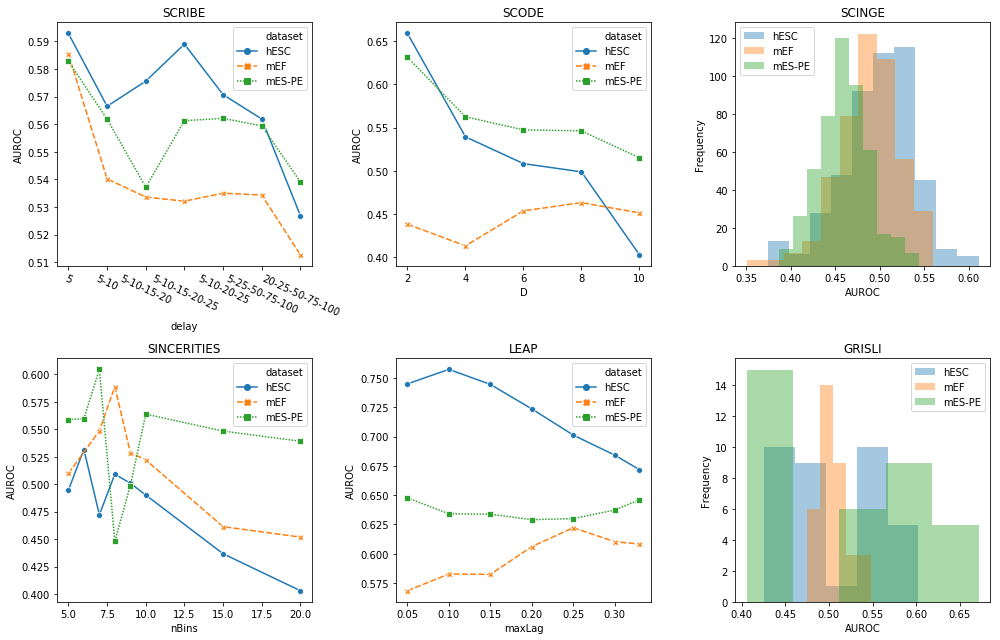

In [259]:
# now plot
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,9))
axes = [axes[0][0], axes[0][1], axes[0][2], axes[1][0], axes[1][1], axes[1][2]]
# f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
# axes = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
for i, alg in enumerate(alg_order):
    ax = axes[i]
    params = alg_params[alg]
    all_df = alg_dfs[alg]
    if len(params) > 1:
#         vals = []
        nbins = 10
        if alg == "GRISLI":
            nbins = 5
        for dataset in all_df['dataset'].unique():
#             vals.append(all_df[all_df['dataset'] == dataset][measure])
            sns.distplot(all_df[all_df['dataset'] == dataset].groupby('params').median()[measure], ax=ax, kde=False, label=dataset, bins=nbins)
#         ax.hist(vals, label=all_df['dataset'].unique())
        ax.set_ylabel('Frequency')
        ax.set_title(alg)
        ax.legend()
    else:
        param = params[0]
        summary_plot(all_df, param, measure, title=alg, rotate=True if alg == 'SCRIBE' else False, ax=ax)
        # make sure the y range is not 3 decimal places
        if alg == "SCRIBE":
            from matplotlib.ticker import FormatStrFormatter
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
plt.tight_layout()
print(out_file)
plt.savefig(out_file)
plt.show()
# plt.close()

In [275]:
# try keeping ties
df = pd.DataFrame([['a', 'b', 0.4], ['a','c',0.3], ['a','d',0.3], ['a','e', 0.3], ['a', 'f', -0.2], ['a', 'a', 0.2]])
df

,0,1,2
0,a,b,0.4
1,a,c,0.3
2,a,d,0.3
3,a,e,0.3
4,a,f,-0.2
5,a,a,0.2


In [283]:
df[2] = df[2].apply(np.abs)
df

,0,1,2
0,a,b,0.4
1,a,c,0.3
2,a,d,0.3
3,a,e,0.3
4,a,f,0.2
5,a,a,0.2


In [288]:
len(df.loc[df[1] == '3'])


0

In [267]:
trueDF = pd.read_csv("/data/jeff-law/projects/2019-04-single-cell/RNMethods/inputs/datasets/human/hESC/refNetwork-string-700.csv")
print(len(np.unique(trueDF.loc[:,['Gene1','Gene2']])))

31


In [270]:
from itertools import product
list(product(np.unique(trueDF.loc[:,['Gene1','Gene2']]), repeat=2))[:10]

[('CDX1', 'CDX1'),
 ('CDX1', 'E2F4'),
 ('CDX1', 'EOMES'),
 ('CDX1', 'FOXH1'),
 ('CDX1', 'GATA3'),
 ('CDX1', 'GATA4'),
 ('CDX1', 'GATA6'),
 ('CDX1', 'HOXB3'),
 ('CDX1', 'HOXB6'),
 ('CDX1', 'LEF1')]

In [271]:
trueDF

,Gene1,Gene2,combined_score
0,SOX2,POU5F1,0.999
1,POU5F1,NANOG,0.999
2,SOX2,NANOG,0.997
3,FOXH1,SMAD2,0.991
4,PITX2,LEF1,0.982
5,GATA4,SRF,0.980
6,ZIC3,NANOG,0.975
7,SOX2,ZIC3,0.967
8,SMAD2,SMAD7,0.962
9,LEF1,CDX1,0.961


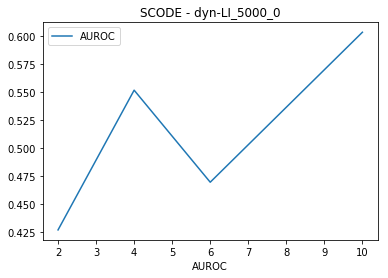

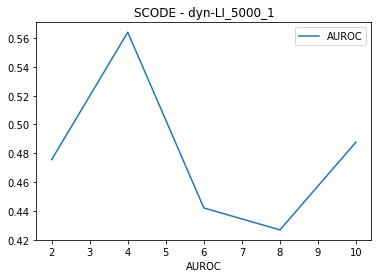

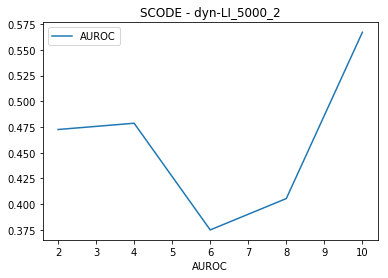

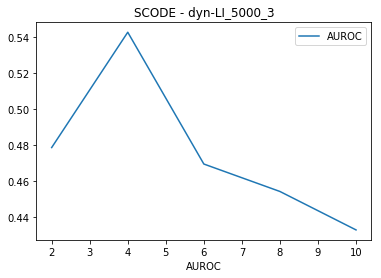

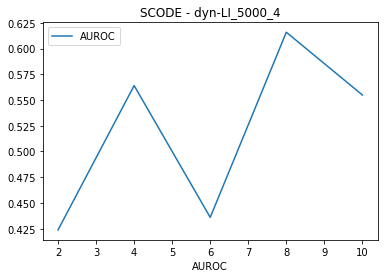

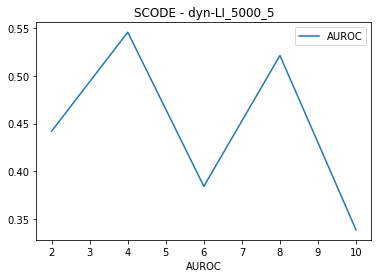

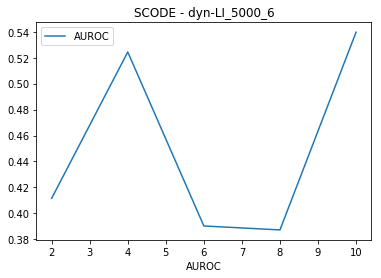

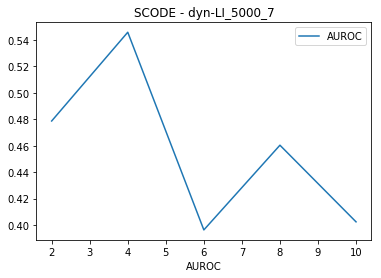

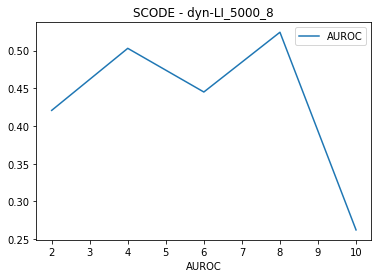

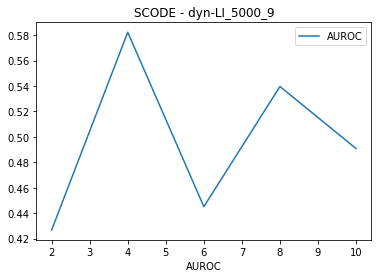

In [192]:
# try plotting a line plot for the methods with only one parameter
for dataset in datasets:
    eval_file = "outputs/simulated/%s/%s/eval.csv" % (simulations, dataset)
    df, params_list = get_dataset(eval_file, alg)
    line_plot_and_best_params(df, alg, dataset, param='D', measure='AUROC')

In [ ]:
# histogram
for dataset in datasets:
    eval_file = "outputs/simulated/%s/%s/eval.csv" % (simulations, dataset)
    df, params_list = get_dataset(eval_file)
    best_params = plot_and_get_best_params(df, alg, dataset, measure='AUROC', quantile=0.99)